In [1]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("symbol-vocab")
# mask_model = AutoModelForMaskedLM.from_pretrained("./symbol-masked-trainer/checkpoint-50000")
# model = AutoModelForSequenceClassification.from_pretrained("./after-bert-trainer/checkpoint-50000", num_labels=2)
# model = AutoModelForSequenceClassification.from_pretrained("./after-bert-random-trainer/checkpoint-50000", num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained("./after-bert-random-symbol-trainer/checkpoint-50000", num_labels=2)
# model.bert = mask_model

Some weights of the model checkpoint at ./after-bert-random-symbol-trainer/checkpoint-50000 were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./after-bert-random-symbol-trainer/checkpoint-50000 and are newly initialized: ['classifier.out_proj.weight', 'classifier.out

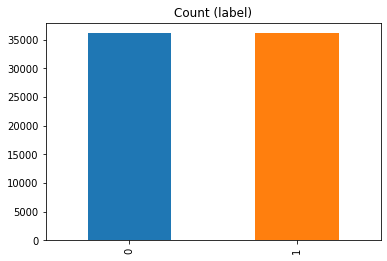

In [2]:
from glob import glob
from datasets import Dataset

import re
import pandas as pd

from parse import data_loading

data_url = '../crawler/stock/data/**.json'
url = glob(data_url)[-1]
data = data_loading(url, is_under_sampling=True)

data['label'].value_counts().plot(kind='bar', title='Count (label)', color=['#1f77b4', '#ff7f0e'])

dataset = Dataset.from_pandas(data.loc[:, ['label', 'sentense']])
dataset = dataset.remove_columns('__index_level_0__')
dataset = dataset.train_test_split(test_size=0.2)

train_dataset = dataset['train']
test_dataset = dataset['test']

In [3]:
def encode(example):
    sentense = example['sentense']

    result = tokenizer(
        sentense,
        padding='max_length',
        truncation=True,
    )
    return result

encoded_train_dataset = train_dataset.map(encode, batched=True)
encoded_test_dataset = test_dataset.map(encode, batched=True)

In [ ]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

import numpy as np
import wandb

runs_name = "fin-bertweet-random-symbol-classifier-balanced-5-epoch-trainer"
%env WANDB_PROJECT=Stocktwit_sentiment_analysis
training_args = TrainingArguments(
    output_dir=runs_name,
    evaluation_strategy="steps",
    eval_steps=100,
    num_train_epochs=5,
    save_steps=5000,
    per_device_train_batch_size=4,
    report_to="wandb",
    run_name=runs_name
)

recall_metric = load_metric("recall")
precision_metric = load_metric("precision")
accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    recall_result = recall_metric.compute(predictions=predictions, references=labels)
    precision_result = precision_metric.compute(predictions=predictions, references=labels)
    accuracy_result = accuracy_metric.compute(predictions=predictions, references=labels)
    f1_result = f1_metric.compute(predictions=predictions, references=labels)
    return {**recall_result, **precision_result, **accuracy_result, **f1_result}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb.finish()